# Text Summarization

Всем привет! Сегодня мы познакомимся с задачей суммаризации текста на примере генерации "сжатых" новостей. Рассмотрим некоторые базовые решения и познакомимся с архитектурами нейросетей для решения задачи.
Датасет: gazeta.ru


`Ноутбук создан на основе семинара Гусева Ильи на кафедре компьютерной лингвистики ABBYY МФТИ.`

Загрузим датасет и необходимые библиотеки

In [1]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [2]:
!pip -q install razdel networkx pymorphy2 nltk rouge==0.3.1 summa youtokentome

## Dataset

Посмотрим на то, как устроен датасет

In [3]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [4]:
import json
import random
import torch

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [5]:
random.seed(42)
torch.random.manual_seed(42)
torch.cuda.random.manual_seed(42)
torch.cuda.random.manual_seed_all(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [7]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

## Extractive RNN

### BPE
Для начала сделаем BPE токенизацию

In [8]:
import youtokentome as yttm

def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

train_bpe(train_records, "BPE_model.bin")

Training parameters
  input: temp.txt
  model: BPE_model.bin
  vocab_size: 10000
  n_threads: 2
  character_coverage: 1
  pad: 0
  unk: 1
  bos: 2
  eos: 3

reading file...
learning bpe...
number of unique characters in the training data: 269
number of deleted characters: 0
number of unique characters left: 269
id: 1000=5+10                 freq: 28916       subword: от=о+т
id: 2000=287+1135             freq: 11492       subword: ▁поясни=▁по+ясни
id: 3000=910+34               freq: 6896        subword: ▁спец=▁спе+ц
id: 4000=313+416              freq: 4697        subword: ▁уси=▁у+си
id: 5000=2327+13              freq: 3394        subword: ▁медведев=▁медведе+в
id: 6000=17+1132              freq: 2611        subword: дзе=д+зе
id: 7000=381+290              freq: 2096        subword: гали=га+ли
id: 8000=284+592              freq: 1723        subword: ▁остави=▁о+стави
id: 9000=470+746              freq: 1461        subword: ▁интри=▁ин+три
model saved to: BPE_model.bin


### Словарь
Составим словарь для индексации токенов

In [9]:
bpe_processor = yttm.BPE('BPE_model.bin')
vocabulary = bpe_processor.vocab()

### Кэш oracle summary
Закэшируем oracle summary, чтобы не пересчитывать их каждый раз

In [10]:
from rouge import Rouge
import razdel
from tqdm.notebook import tqdm

import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Составление батчей

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
import random
import math
import razdel
import torch
import numpy as np
from rouge import Rouge


class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True, lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        self.pad_index = 2
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)
                
                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences)[1]
                else:   
                    sentences_indicies = record["oracle_sentences"]
                
                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                
                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)
                
            # we add index 2 for padding
            tensor_inputs = torch.full((self.batch_size, max_sentences, max_sentence_length), self.pad_index, dtype=torch.long, device=self.device)
            tensor_outputs = torch.full((self.batch_size, max_sentences), self.pad_index, dtype=torch.float32, device=self.device)

            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)
#                     tensor_inputs[i][j][len(sentence_tokens):] = torch.tensor(2, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            tensor_outputs = tensor_outputs.long()
            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [13]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 32, bpe_processor, device=device, )
val_iterator = BatchIterator(ext_val_records, vocabulary, 32, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)

## Extractor -  SummaRuNNer
 https://arxiv.org/pdf/1611.04230.pdf


### Homework

* [x] В данной реализации в `outputs` в качестве padding используется индекс 0. Измените в функции `__iter__` индекс padding, чтобы он не совпадал с классом 0 или 1, например, 2.
* [x] В качестве criterion используйте `CrossEntropyLoss`вместо `BCEWithLogitsLoss`
* Из-за смены criterion, вы уже должны подавать на вход criterion ни одно число, а logits для каждого класса. Перед подачей logits вы можете отфильтровать предсказания для класса padding. В этом пункте вам придется изменять файл `train_model.py`, а именно функциии `train` и `evaluate`.
* Используйте два варианта обучения: c весами в `CrossEntropyLoss` и без
* Также сравните `inference`, когда вы ранжируете logits, и когды вы выбирате предложения, у котрых logits > 0, в двух вариантах обучения. 
* Реализуйте дополнительно характеристику предложения `novelty`. Как влияет добавление `novelty` на качество summary?
* Постарайтесь улучшить качество модели, полученной на семинаре: $BLEU \approx 0.45$

In [14]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.pos_embedding_layer = nn.Embedding(50, embedding_dim)
        
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        batch_size = inputs.shape[0]
        sent_length = inputs.shape[1]

        pos = torch.arange(0, sent_length).unsqueeze(0).repeat(batch_size, 1).to(device)
        
        token_embedded = self.dropout_layer(self.embedding_layer(inputs))
        pos_embedded = self.dropout_layer(self.pos_embedding_layer(pos))
        
        embedded = self.dropout_layer(token_embedded + pos_embedded)
        
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        
        return sentences_embeddings # -> [batch_size, hidden_size]

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_content=True,
                 use_salience=True,
                 use_novelty=True,
                 token_embedding_dim=128,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=2,
                 dropout=0.3):
        
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.novelty_linear_layer =  nn.Linear(hidden_size * 2, hidden_size * 2)
        self.tanh_layer = nn.Tanh()
        
        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty

    def forward(self, inputs, hidden=None):  # inputs -> [batch_size, seq num, seq_len]
        # parameters of the probability
        content = 0
        salience = 0
        novelty = 0

        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count) # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        
        # embedded_sentences -> [batch_size *  seq num, seq_len, hidden_size] -> [batch_size, seq num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden) # [batch_size, seq num, hidden_size]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1))) # [batch_size, hidden_size]

        # W * h^T
        if self.use_content:
            content = self.content_linear_layer(outputs).squeeze(2) # 1-representation -> [batch_size, seq num]

        # h^T * W * d
        if self.use_salience:
            salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2)
        # 2-representation
        # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]

        if self.use_novelty:
            # at every step add novelty to prediction of the sentence
            predictions = content + salience
            
            # 0) initialize summary_representation and novelty by zeros
            summary_representation = torch.zeros(outputs.size()).to(device) # [batch_size, seq num, ]
            novelty = torch.zeros(batch_size, sentences_count).to(device) # [batch_size, seq num, ]
            probabilities = torch.zeros((batch_size, sentences_count)).to(device) # [batch_size, seq num, ]

            for sentence_num in range(sentences_count):
                
                # 1) take sentence_num_state from outputs(representation of the sentence with number sentence_num)
                sentence_num_state = outputs[:, sentence_num, :] # [batch_size, hidden_size]
                
                # 2) calculate novelty for current sentence
                # novelty = h^T * W * tanh(sj)
                tanh_sj = self.novelty_linear_layer(self.tanh_layer(sentence_num_state)).unsqueeze(2)
                novelty[:, sentence_num] = torch.bmm(outputs[:, [sentence_num], :], tanh_sj).squeeze(1).squeeze(1)
                
                # 3) add novelty to predictions
                preds = predictions[:, sentence_num].clone() + novelty[:, sentence_num].clone()
                
                # 4) calculcate probability for current sentence
                probabilities[:, sentence_num] = torch.sigmoid(preds)
                
                # 5) add sentence_num_state with the weight which is equal to probability to summary_representation
                summary_representation[:, sentence_num, :] = (outputs[:, :sentence_num, :].clone() * probabilities[:, :sentence_num].unsqueeze(2).clone()).sum(dim=1)
                
        result = predictions - novelty
        result = torch.cat([-result.unsqueeze(1), result.unsqueeze(1)], dim=1) 
        return result

## Model
$P\left(y_{j} = 1 \mid \mathbf{h}_{j}, \mathbf{s}_{j}, \mathbf{d}\right)=\sigma\left(W_{c} \mathbf{h}_{j} + \mathbf{h}_{j}^{T} W_{s} \mathbf{d}\right)$
--------------------

In [16]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 2934017


In [19]:
# cp ../input/train-model-2/train_model.py ./

In [20]:
import train_model
from train_model import train_with_logs

from torch.optim import lr_scheduler

In [22]:
def start_train(use_class_weights, N_EPOCHS, CLIP, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)
    
    if use_class_weights:
        # weights depend on the number of objects of class 0 and 1
        weights = {0: 0, 1: 0}
        for batch in train_iterator:
            counts = torch.unique(batch['outputs'], return_counts=True)
            batch_dict = dict(zip(counts[0].cpu().numpy(), counts[1].cpu().numpy()))
            weights[0] += batch_dict[0]
            weights[1] += batch_dict[1]
        total = weights[1] + weights[0]
        # check order
        print("criterion with weights: ", weights)
        weights = torch.Tensor(np.array([weights[0] / total, weights[1] / total])).to(device)
        criterion = nn.CrossEntropyLoss(ignore_index=train_iterator.pad_index, weight=weights)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=train_iterator.pad_index)
    train_with_logs(model, train_iterator, val_iterator, optimizer, scheduler, criterion, N_EPOCHS, CLIP)
    
def inference_summarunner(model, iterator, top_k=3):

    references = []
    predictions = []

    model.eval()
    for batch in iterator:

        logits = model(batch['inputs'])
        logits = logits[:, 1, :]  # batch_size, classes(0, 1), num_sentences
        logits = logits * torch.tensor(batch['outputs'] != iterator.pad_index).float()
        logits[logits == 0.] = float("-Inf")
        sum_in = torch.argsort(logits, dim=1)[:, -top_k:]
        for i in range(len(batch['outputs'])):

            summary = batch['records'][i]['summary'].lower()
            pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i]])

            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)
    calc_scores(references, predictions)

## Training model

In [25]:
N_EPOCHS = 50
CLIP = 5

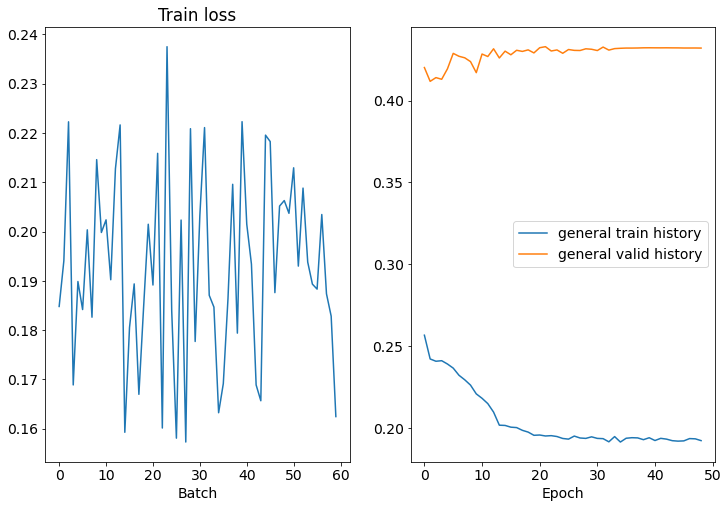

0it [00:00, ?it/s]

Epoch: 50 | Time: 0m 10s


In [26]:
start_train(False, N_EPOCHS, CLIP)

In [27]:
model.load_state_dict(torch.load('./best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Count: 256
Ref: депутат бундестага от « альтернативы для германии » антон фризен заявил , что антироссийские санкции « не вернут крым украине » . по его словам , российский флаг над полуостровом — это реальное положение дел . основным выгодополучателем от санкций против рф является вашингтон , добавил немецкий парламентарий . именно фризен ранее внес законопроект об отмене санкций , но бундестаг отклонил эту инициативу .
Hyp: европейские санкции против россии не изменят статуса крыма , заявил депутат бундестага от « альтернативы для германии » ( afd ) антон фризен . об этом сообщает риа « новости » . « крым однозначно останется российским , это реальное положение дел » , — подчеркнул парламентарий .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.31733181247536923, 'p': 0.30313415143950334, 'r': 0.35319675634542913}, 'rouge-2': {'f': 0.14277322190268435, 'p': 0.13475932187114886, 'r': 0.16339726182715164}, 'rouge-l': {'f': 0.27154623032757486, 'p': 0.27392581203986127, 'r': 0.318

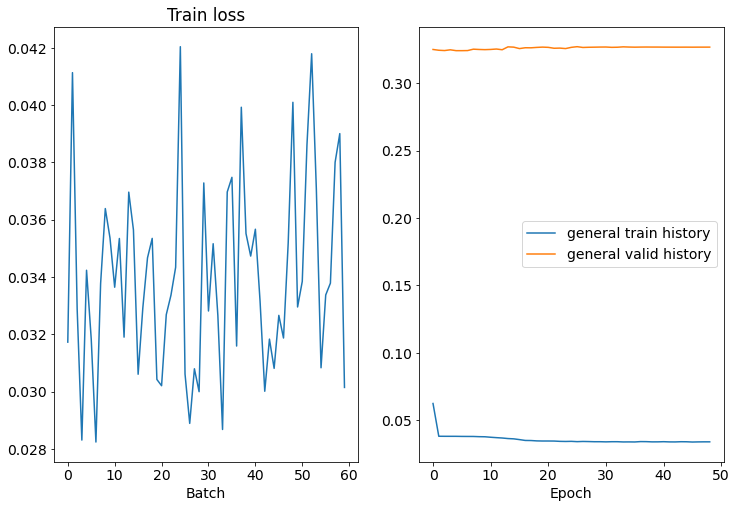

0it [00:00, ?it/s]

Epoch: 50 | Time: 0m 11s


In [28]:
model = SentenceTaggerRNN(vocab_size).to(device)
start_train(True, N_EPOCHS, CLIP)

In [29]:
model.load_state_dict(torch.load('./best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Count: 256
Ref: опасные трещины найдены уже в десятках самолетов boeing 737 ng . американскому производителю , чьи новейшие лайнеры и так прикованы к земле из-за двух авиакатастроф , теперь грозят новые убытки .
Hyp: подозрения , павшие почти две недели назад на один из самых массовых самолетов в мире boeing 737 ng , подтвердились и теперь могут привести к отзыву треснувших самолетов , а для boeing — обернуться новыми репутационными и финансовыми потерями . как сообщают американские сми , число дефектных самолетов уже измеряется десятками . о новой проблеме с популярными лайнерами семейства boeing 737 стало известно в конце сентября , когда инженеры компании случайно обнаружили трещины в их конструкции .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.31733181247536885, 'p': 0.30313415143950345, 'r': 0.3531967563454291}, 'rouge-2': {'f': 0.14277322190268438, 'p': 0.13475932187114895, 'r': 0.16339726182715167}, 'rouge-l': {'f': 0.27154623032757486, 'p': 0.273925812039861, 'r': 0.3

In [5]:
!pip install pandoc

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
     |████████████████████████████████| 117 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 1.2 MB/s eta 0:00:01
  Created wheel for pandoc: filename=pandoc-2.2-py3-none-any.whl size=29552 sha256=b14ea9e830d6b166ca0a338750ff1dd3bc2b77928beb890630f82293b2c47466
  Stored in directory: /home/kirill/.cache/pip/wheels/2d/da/b1/54ff0401ef9b07b60c7fc9cffe616f243cf27dc3d04bd5d5ef
Successfully built pandoc
